<img src="https://i.postimg.cc/gJkb4Srp/deeplearning-meme-1.jpg" width="700" height="500">

# Contents

* [<font size=4>Introduction</font>](#1)
* [<font size=4>Import Libraries and read Data</font>](#2)
* [<font size=4>First look of the Data</font>](#3)
* [<font size=4>Let's explore the mess</font>](#4)
 *     [Let's look at some of those damn pictures](#4.1)
 *     [Let's look at the pixel distribution of each picture](#4.2)
 *     [How many elements of each digit do we have ?](#4.3)
 *     [Let's see this in 3D space](#4.4)
 *     [Let's Prepare these Digits](#4.5)
* [<font size=4>Hyperparameter Optimization</font>](#5)
 *     [Let's cleanly prepare our vacation photos](#5.1)
 *     [Grid Search](#5.2)
 *     [Random Search](#5.3)
 *     [Bayésien Optimisation](#5.4)
* [<font size=4>Conclusion</font>](#6)

## Introduction <a id="1"></a>

This notebook provides an overview on building a simple sequential Neural Network using Tensorflow Keras API and then finding the best hyperparameters to increase its accuracy using different approaches by evaluating their reliability and the time it takes them to get there.

The first part of the notebook is an exploratory analysis that we will use for this experiment.

Thereafter, we will do Data engineering to favor the diversity of our Dataset.

Finally the most important part is the optimization of the parameters of the network in order to increase its performance.

I do this experiment after having completed the theoretical courses provided by <a href="https://www.coursera.org/specializations/deep-learning">deeplearnong.ai</a> i recommend to everyone and also the excellent conference of  <a href="https://www.youtube.com/watch?v=BtAVBeLuigI&t=6823s">Martin Görner</a> if you speak French =)

<img src="https://i.postimg.cc/Fs2mmVCb/nnmeme3.png" align="right" width="300" height="200">

I apply this exercise to recognize handwritten digits presented on photos of 28 x 28 pixels but we can apply this methodology very well for other problems. wait, i will even say, it is recomendable to apply this methodology for other problems with input data which are neither images or videos because a convolutional neural network (CNN) which I do not use here performs far better than a standard neural network.

A trivial sequential neural network can have good results if we choose the right configuration and combine it with other neural networks or other algorithms.

Enough talking leave room for the most important ! 

<BR CLEAR=”left” />

# Import Libraries and read Data <a id="2"></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import tqdm
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from bayes_opt import BayesianOptimization

import time
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
!pip install MulticoreTSNE
from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.manifold import TSNE
import plotly.express as px

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
random_state = 42
np.random.seed(random_state)

df_train = pd.read_csv('../input/digit-recognizer/train.csv')
df_test = pd.read_csv('../input/digit-recognizer/test.csv')
submission = pd.read_csv('../input/digit-recognizer/sample_submission.csv')

Using TensorFlow backend.


  Created wheel for MulticoreTSNE: filename=MulticoreTSNE-0.1-cp37-cp37m-linux_x86_64.whl size=68502 sha256=21ea4c18ff836aa10ea8a83d53cc938a091a9f4dce685c5d905208521d9f9313
  Stored in directory: /root/.cache/pip/wheels/80/47/df/c0d66e9f775f33281c422a1964de86a59c47f93bb8c37643e3
Successfully built MulticoreTSNE
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/sample_submission.csv


# First look of the Data <a id="3"></a>

In [2]:
print('Train data Info : ' )
df_train.info()

print('\nTest data Info : ')
df_test.info()

print('\nThere is ' + str(df_train.isnull().sum().sum()) + ' missing values in Train data')
print('\nThere is ' + str(df_test.isnull().sum().sum()) + ' missing values in Train data')

print('\nTrain first 5 rows')
display(df_train.head())

print('\nTest first 5 rows')
df_train.head()

Train data Info : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB

Test data Info : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB

There is 0 missing values in Train data

There is 0 missing values in Train data

Train first 5 rows


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



Test first 5 rows


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We have 42,000 learning inputs and 28,000 test inputs, making a total of 70,000 images.

The first column of our data is "label" it contains the digit represented by the line, it goes from 0 to 9.

the labels are present on the training data only, it is up to us to predict the label of the test data.

The rest of the columns (pixel0 to pixel783) contain the gray shade of each pixel which constitutes the image, the resolution of the images is 28 x 28 which is flattened in a vector of 784 boxes represented by these columns.

The shade of gray goes from 0 to 255, 0 is white and 255 is black and between them it is shades of gray.

# Let's explore the mess <a id="4"></a>

## Let's look at some of those damn pictures <a id="4.1"></a>

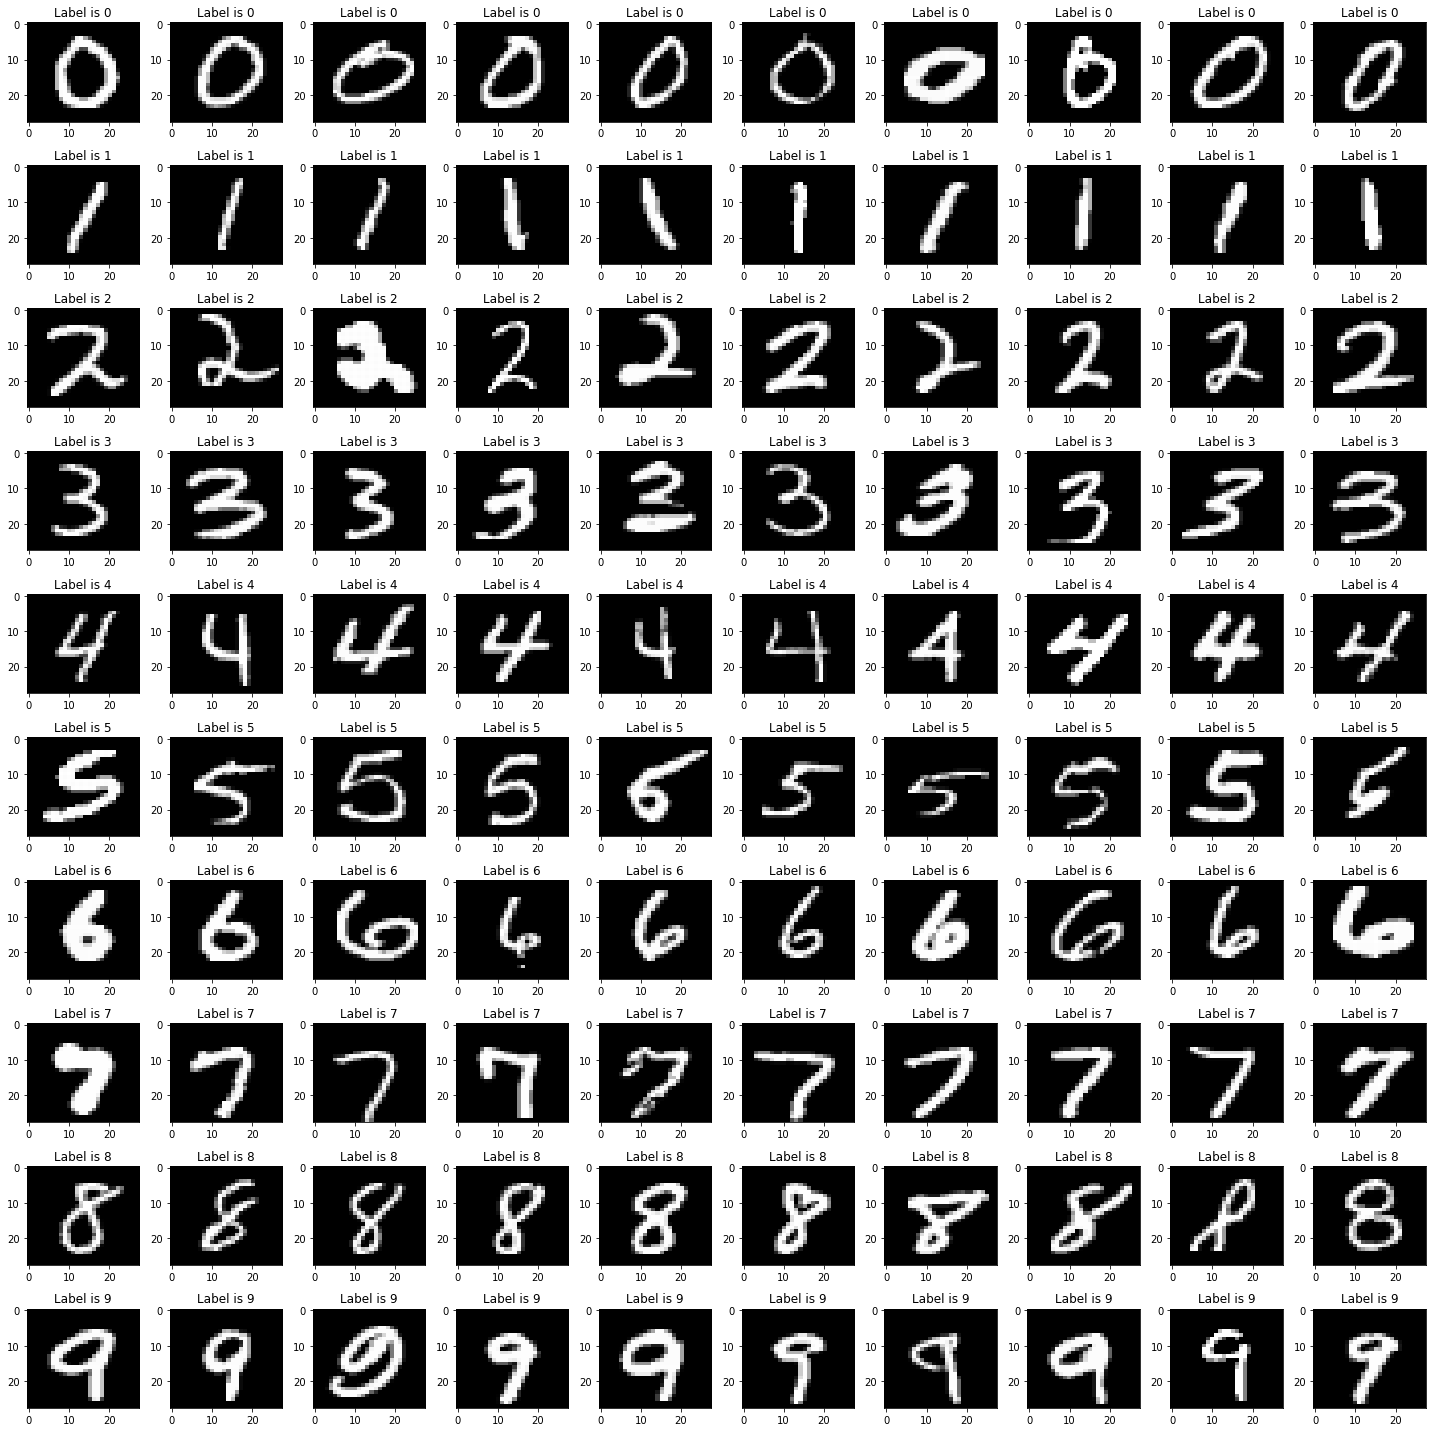

In [3]:
labels = sorted(df_train['label'].unique())
fig = plt.figure(figsize = [20,20])
i = 1
for l in labels :
    for data in df_train[df_train['label'] == l].sample(n=10, random_state=random_state).values :
        plt.subplot(10, 10, i)
        label = data[0]
        pixels = data[1:]
        pixels = np.array(pixels, dtype='uint8')

        pixels = pixels.reshape((28, 28))

        plt.title('Label is {label}'.format(label=label))
        plt.imshow(pixels, cmap='gray', aspect='auto')
        i = i+ 1
plt.tight_layout()
plt.show()

These are small images in which we can easily distinguish a digit between 0 and 9 written with hands and sometimes with feet, our algorithm will have a hard time predicting them.

## Let's look at the pixel distribution of each picture <a id="4.2"></a>

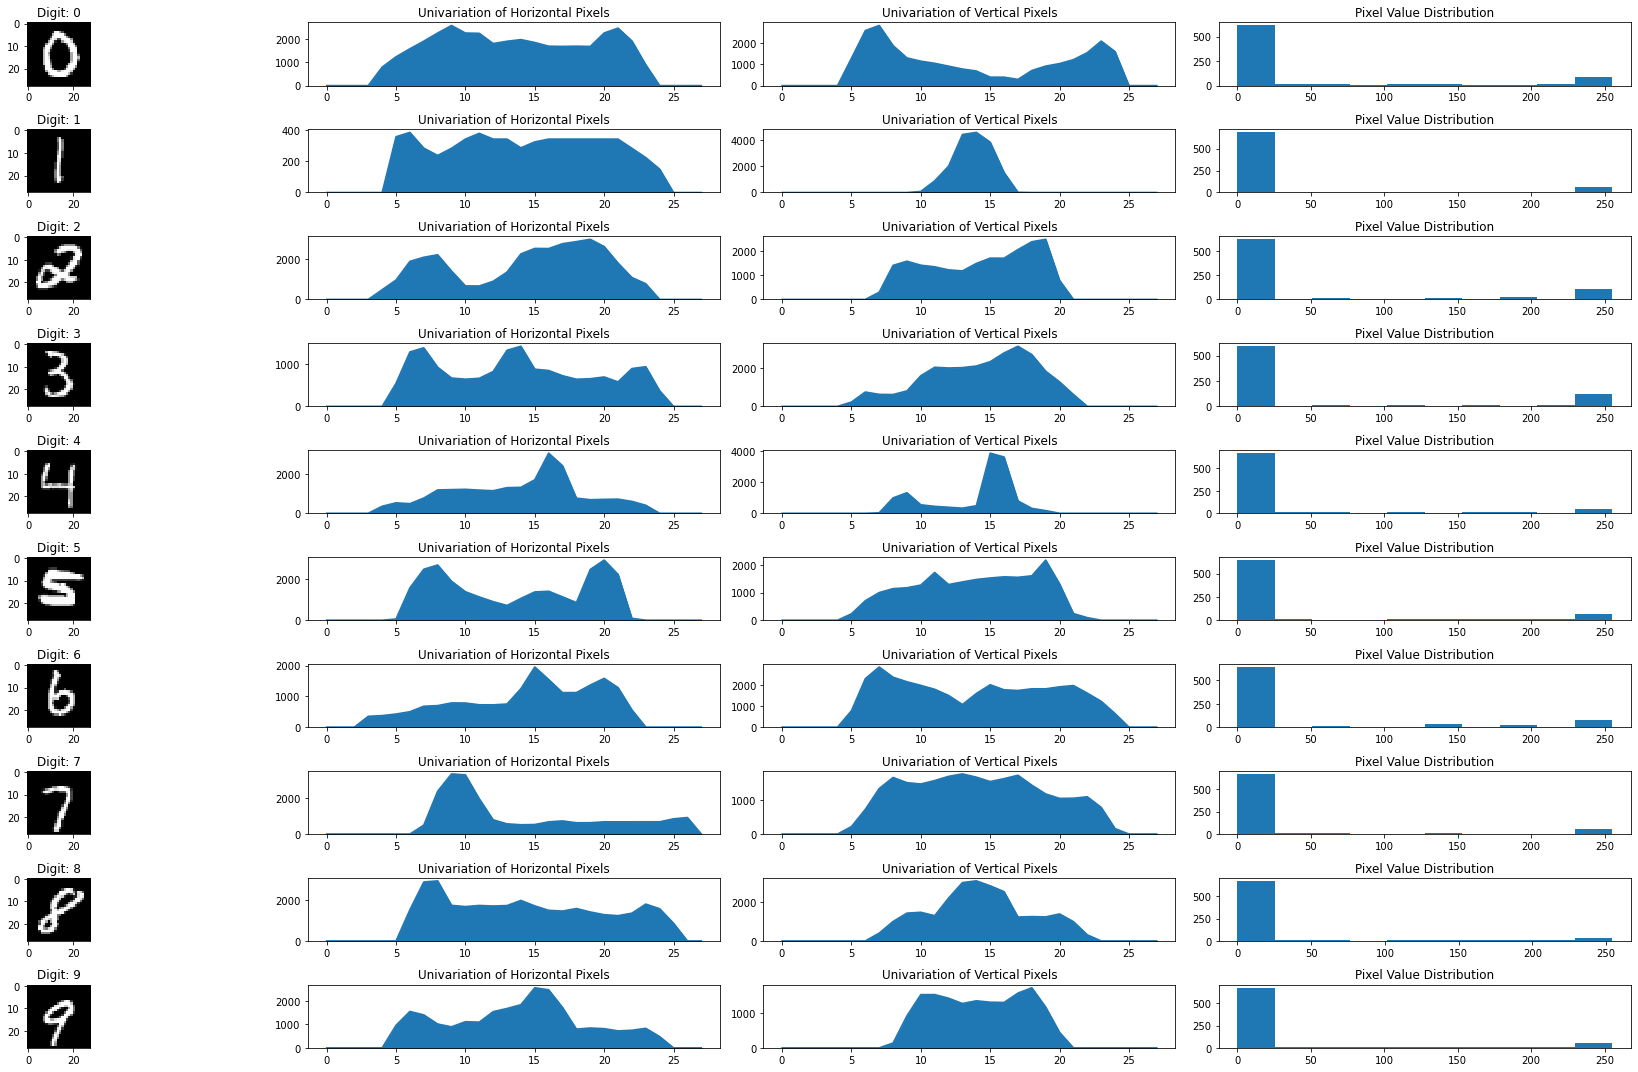

In [4]:
plt.figure(figsize=(25, 15))
j = 1
for i in range(10) :
    plt.subplot(10,4,j)
    j +=1
    plt.imshow(df_train[df_train['label'] == i].sample(1).drop(labels = ["label"],axis = 1).values.reshape(28, 28), cmap='gray', interpolation='none')
    plt.title("Digit: {}".format(i))
    plt.subplot(10,4,j)
    j +=1
    pd.DataFrame(df_train[df_train['label'] == i].sample(1).drop(labels = ["label"],axis = 1).values.reshape(28, 28)).sum(axis = 1).plot.area(title = 'Univariation of Horizontal Pixels')
    plt.subplot(10,4,j)
    j +=1
    pd.DataFrame(df_train[df_train['label'] == i].sample(1).drop(labels = ["label"],axis = 1).values.reshape(28, 28)).sum(axis = 0).plot.area(title = 'Univariation of Vertical Pixels')
    plt.subplot(10,4,j)
    j +=1
    plt.hist(df_train[df_train['label'] == i].sample(1).drop(labels = ["label"],axis = 1))
    plt.title("Pixel Value Distribution")
plt.tight_layout()


On the far left we have the digit in question to draw at random.

In the middle we have Univariation of Horizontal Pixels and Univariation of Vertical Pixels which are respectively the sum of the pixel values of the horizontal axis and the vertical axis of the left image.

We notice that the variation is different between the images, for example the zero is symmetrical and the sum of the pixels of the two axes is practically identical. the same for the one and eight.

On the other hand the three is asynmetric what makes that the sum of the pixels of each axis is not homogeneous. the same for the rest of the digits.

This can be good news because there is a simple way of distinguishing between zero, one and eight and the rest of the digits, if they are well written of course.

On the far right we have the distribution of the 255 shades of gray in the image on the left.

We notice that the white pixels (value 0) is very present and which are followed by far by the black pixels (value 255).

this means that the gray pixels are present mainly in the borders between the black pixels and the white pixels and they are few.

## How many elements of each digit do we have ? <a id="4.3"></a>

[Text(0, 0.5, 'Degits'), Text(0.5, 0, 'Count')]

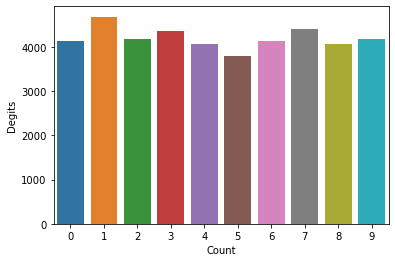

In [5]:
ax = sns.barplot(x="index", y="label", data=df_train.label.value_counts().to_frame().sort_index().reset_index())
ax.set(xlabel='Count', ylabel='Degits')

Around 4000 of each digit, it's balanced.

## Let's see this in 3D space <a id="4.4"></a>

In [6]:
X_train = df_train.drop(labels = ["label"],axis = 1)
Y_train = df_train["label"]
Y_train = to_categorical(Y_train, num_classes = 10)
X_train /= 255

X_embedded = TSNE(n_components=3, n_jobs=1).fit_transform(X_train)
tsne_plot = pd.DataFrame(X_embedded)
tsne_plot.columns = ['tsne_axe1','tsne_axe2','tsne_axe3']
tsne_plot['digits'] = df_train["label"].astype('str')
fig = px.scatter_3d(tsne_plot, x='tsne_axe1', y='tsne_axe2', z='tsne_axe3',
              color='digits',  size_max=18)
fig.show()

<img src="https://i.postimg.cc/R0dj37dD/tsne.png" align="right" width="400" height="300">

This is a 3D representation of the 784 pixels, this resizing is done using TSNE (t-distributed stochastic neighbor embedding).
To simplify, TSNE projects the points in the final dimension (here it is 3 dimensions) then it brings together or removes these points by calculating their similarity.
<a href="https://www.youtube.com/watch?v=NEaUSP4YerM">Check this</a>

In this 3D space, there are 9 clusters of dots of different colors, each cluster represents a digit. so we can deduce that the digits are similar to each other. However, we can clearly see that some points are not in the clusters where they are supposed to be. these points are digits that are written in a way that they look like other digits.

those will cause a problem.

<BR CLEAR=”left” />

## Let's Prepare these Digits <a id="4.5"></a>

In [7]:
X_train = df_train.drop(labels = ["label"],axis = 1)
Y_train = df_train["label"]
Y_train = to_categorical(Y_train, num_classes = 10)

X_train = X_train.values.reshape(X_train.shape[0], 28, 28, 1)
X_test = df_test.values.reshape(df_test.shape[0], 28, 28, 1)

datagen = ImageDataGenerator(rotation_range=10,
                             zoom_range = 0.1,
                             width_shift_range=0.1,
                             height_shift_range=0.1)

dict_ = {}
batchs = datagen.flow(X_train, Y_train, batch_size=1)
for i in range(784) :
    indx = 'pixel' + str(i)
    dict_[indx] = []
dict_['label'] = []
k = 0
counter = 0
for x_batch, y_batch in tqdm.tqdm(datagen.flow(X_train, Y_train, batch_size=1)):
    for i in range(28):
        for j in range (28):         
            indx = 'pixel' + str(k)
            dict_[indx].append(float(x_batch[0][i][j][0]))
            k = k+1
    dict_['label'].append(np.where(y_batch[0] == 1.)[0].item(0))
    k = 0
    counter += 1
    if counter > 10**5:
        break

df_train = pd.DataFrame.from_dict(dict_)
del dict_

100000it [04:49, 345.25it/s]


<img src="https://i.postimg.cc/c1P44Wr8/data-gen.png" align="right" width="600" height="500">

To diversify our images I decided to make use of the ImageDataGenerator functionality of the Keras library which allows to apply various modifications to a basic image batch.
I chose a zoom in or out of 1%, a left or right rotation of 10 degrees and a shift in length or width of 10%.

I did this by reconstructing the 28 x 28 images from the 784 pixel vectors, then I injected these images into the ImageDataGenerator function, mentioning the modifications it should apply, I generated 100,000 images with the 42000 basic and finally I restored the state of origin of the data by flattening these resulting images.

The objective of this increase and diversification of data is to create a greater generalization of training data and that gives them more possibility of containing examples of real life. the more the training data is divided, the less chance that the algorithm will fall into overfitting.

<BR CLEAR=”left” />

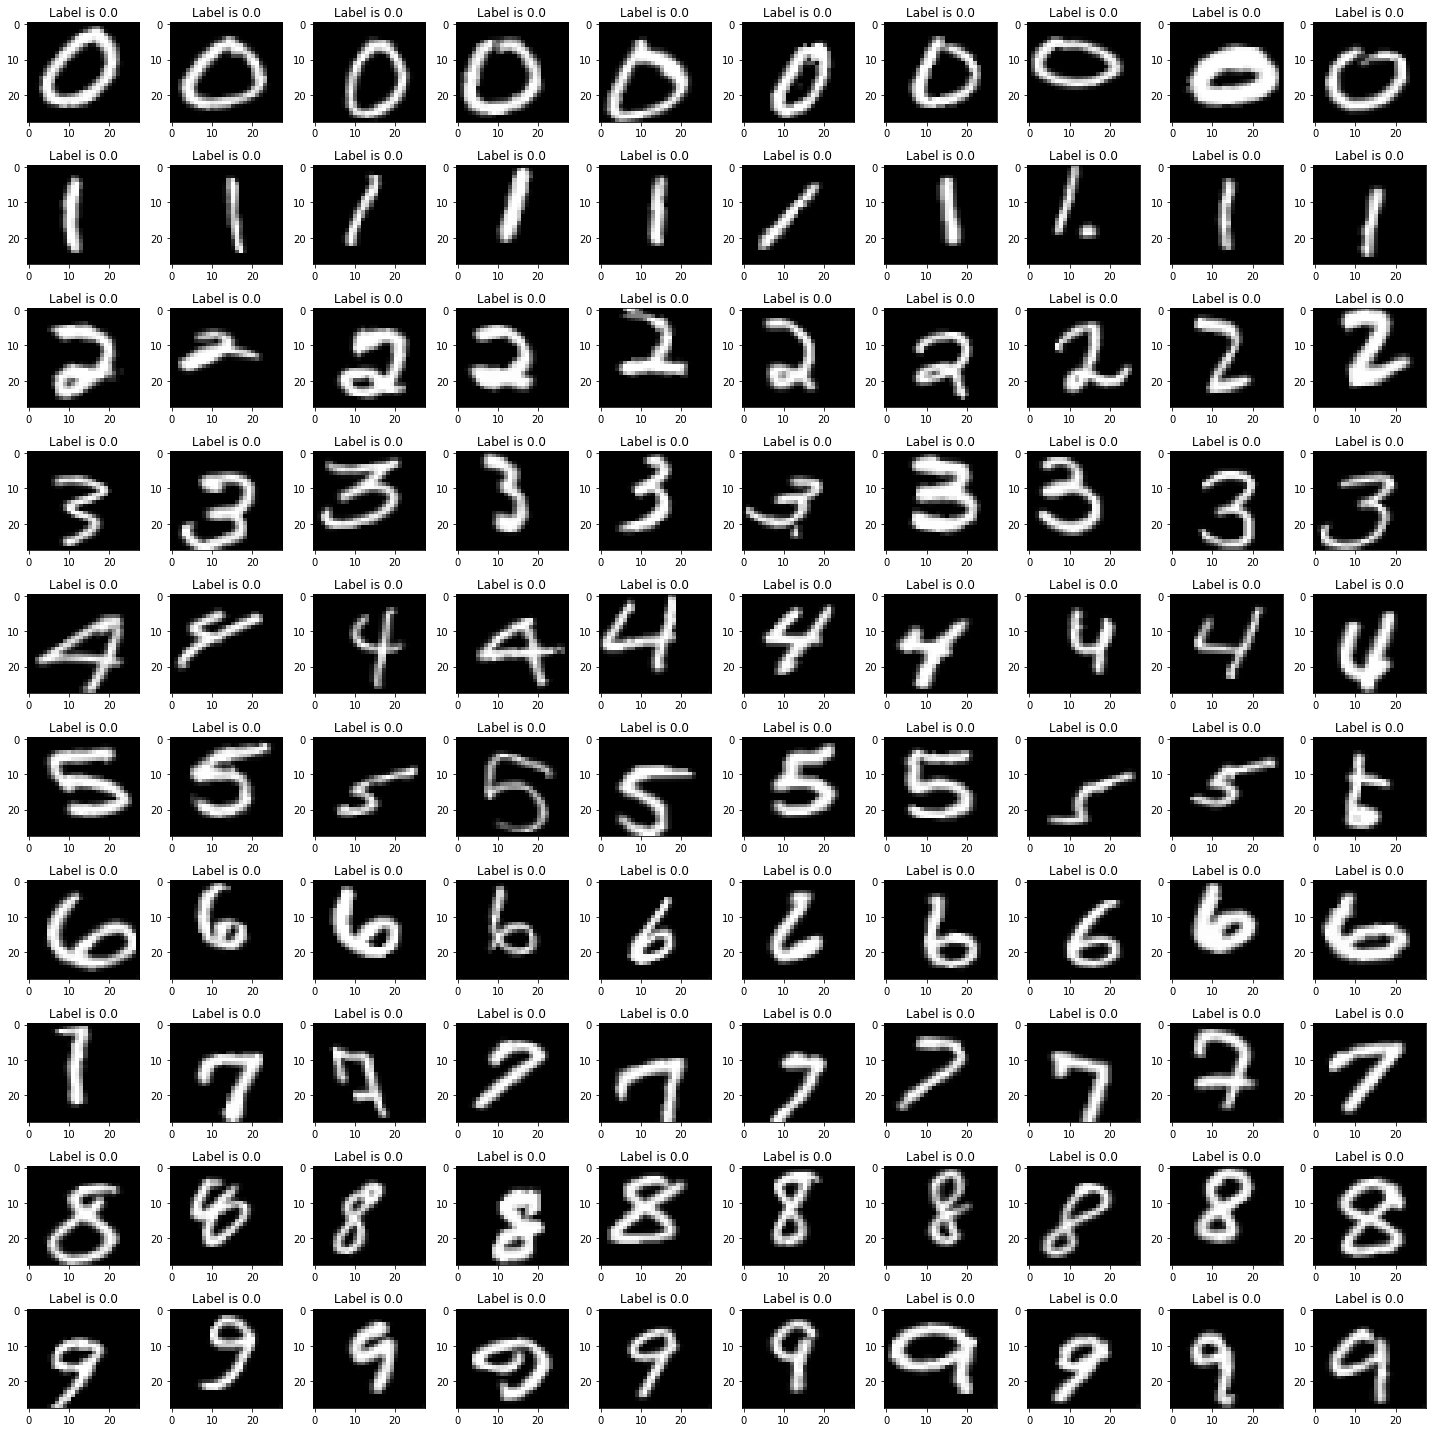

In [8]:
labels = sorted(df_train['label'].unique())
fig = plt.figure(figsize = [20,20])
i = 1
for l in labels :
    for data in df_train[df_train['label'] == l].sample(n=10, random_state=random_state).values :
        plt.subplot(10, 10, i)
        label = data[0]
        pixels = data[1:]
        pixels = np.array(pixels, dtype='uint8')

        pixels = pixels.reshape((28, 28))

        plt.title('Label is {label}'.format(label=label))
        plt.imshow(pixels, cmap='gray', aspect='auto')
        i = i+ 1
plt.tight_layout()
plt.show()

We can clearly distinguish digits facing or shifted towards one of the edges.

[Text(0, 0.5, 'Degits'), Text(0.5, 0, 'Count')]

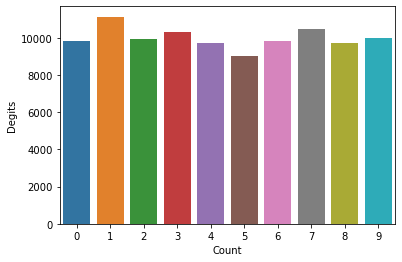

In [9]:
ax = sns.barplot(x="index", y="label", data=df_train.label.value_counts().to_frame().sort_index().reset_index())
ax.set(xlabel='Count', ylabel='Degits')

The balancing of the digits remained the same.

# Hyperparameter Optimization <a id="5"></a>

## Let's cleanly prepare our vacation photos <a id="5.1"></a>

In [10]:
X_train = df_train.drop(labels = ["label"],axis = 1)
Y_train = df_train["label"]
Y_train = to_categorical(Y_train, num_classes = 10)

X_train /= 255

X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.1, random_state=random_state)

<img src="https://i.postimg.cc/rppLNZDk/Cross-validation.png" align="bottom" width="800" height="400">

Now we will split our 100k images into 2 groups.

The first group which will contain 90% of the images will serve to train our neural network and find the best hyperparameters of our network and the second group which will contain only 10% of the images that the network has not seen during training which will be used to evaluate the neural network at the end.

I normalized the pixel value between 0 and 1 instead of 0 and 254 because neural networks feel uneasy with this data interval.

I also apply the one hot encoding on the digital labels
ex: 2 -> [0,0,1,0,0,0,0,0,0,0,0]

<BR CLEAR=”topum” />

In [11]:
batch_size = [256, 512]
epochs = [10, 20]
optimizer = ['RMSprop', 'Adam']
neurons = [512, 1024]

def create_model(neurons=neurons, epochs=epochs, optimizer=optimizer, batch_size=batch_size):
    model = Sequential()
    model.add(Dense(neurons, input_dim=784, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

model_BayesianOptimization = KerasClassifier(build_fn=create_model, verbose=0)
model_GridSearch = KerasClassifier(build_fn=create_model, verbose=0)
model_RandomSearch = KerasClassifier(build_fn=create_model, verbose=0)

param_opt = dict(batch_size=batch_size, epochs=epochs, neurons=neurons, optimizer = optimizer)

We are creating our first neural network which we will optimize.

This neural network contains hyperparameters which i fixed at the start and others which remain dynamic which we must optimize and find the right combination which allows to have optimal performances.

Why did I fix some and not others ? it is for lack of time and computing power, even if Kaggle puts at our disposal GPUs and TPUs which considerably boost the learning speed but it remains too long = /

For these reasons i chose only some hyper parameters to optimize and fix others.

Those that i fixed are supposed to be the most optimal according to other studies so they will not be able to cannibalize the performances.

The hyperparameters that I fixed :
* Neural network layer numbers I chose 2 hidden layers and an output layer. the higher the number of layers, the higher the network has a degree of freedom, if we choose more layers than necessary we fall into overfitting. and the opposite leads to underfitting.

* The activation functions of each layer, I chose re-read for the hidden layers and softmax for the output.why reread, honestly I don't know and few people can explain this, it's just that there is a guy who was inspired by biomimetism who tried and it worked well. Softmax because this function exaggerates the differences between the 1 and the 0 of the output layer, as we have 10 output neurons and each one corresponds to a digit (0 to 9) the neuron with the highest score wins and represents the prediction, and softmax is perfect for that because it increases the value above 0.5 and decreases the value below 0.5.

<img src="https://i.postimg.cc/ryjCvhmb/dropout.jpg" align="right" width="200" height="100">

* The dropout eliminates a percentage of neurons at random from each layer at each iteration which reduces the degree of freedom of the network and it works quite well against overfitting.

<BR CLEAR=”left” />

* The error function is categorical crossentropy, it is a function that calculates the difference between the predicted output and the real output, it gives us how wrong our model is, the objective of learning is to minimize this function as much as possible using the optimization algorithm. It calculates this distance by multiplying the elements of the hot encoded vector of the real output by the predicted output.

<img src="https://i.postimg.cc/5yKzjRQ2/loss.png" width="400" height="200">

* The metric that calculates the performance of the model is the accuracy which is simply (the digits predict correctly) / (all the digits).

The dynamic hyperparameters that we have to find :

* Batch size is the size of the batch of images that the model will see before he updates his weights and biases so that he minimizes categorical crossentropy. the size of the batch defines the speed and stability of the network. I have chosen the values 256 and 512, it is preferable to choose a multiple of 2.

* The epoch is the number of times that the network goes around all the training data. If the epoch number is too large, this can lead to overfitting.

<img src="https://i.postimg.cc/8PqF3Wh9/optimiser2.png" align="right" width="300" height="200">
* The optimizer is the algorithm which will modify the weights and biases of the network to reach the minimum of the error function, in other words it reduces the error and it is the engine of learning, I chose the two most popular: Adam and RMSprop, both do the same work, that is to say they find the minimum of the error function but their particularity is that they accelerate the step to reach the minimum in the goal that learning does not take much time and also that the network is not trapped in a shallow minimum which is the local minimum. The difference between Adam and RMSpro and that Adam uses the principle of RMSprop and he adds another accelerator called the momentum.
<BR CLEAR=”left” />

* Finally the number of neurons of each layer which define the degree of freedom of the network, if the number is too high that can cause an overfitting and if it is small it generates an underfitting. I took 512 and 1024 which is high but we have generated 100,000 images to teach this network and for it to model well it must be quite large.

* Why did I take 4 hyper parameters to optimize and 2 examples of each? Because it's already a lot, you'll see how long it will take when I run the optimizers. If you have ultra powerful GPUs test all hyperparameters. have fun =).




## Grid Search <a id="5.2"></a>

In [12]:
grid = GridSearchCV(estimator=model_GridSearch, param_grid=param_opt, n_jobs=1, cv=3, verbose = 0)
grid_result = grid.fit(X_train, Y_train)
#it tooked 80.5min

Grid search is a way to find the best hyper parameters by evaluating all possible combinations of these.

As we have 4 hyper parameters with 2 possibility of each, that makes 2 x 2 x 2 x 2 = 16 possible combinations, and as we evaluate the model in cross validation with 3 folds that makes 16 x 3 = 48 fits of the network and that is huge it will take a considerable time.

If each fit is done in 2 minutes, everything ends in 1 hour and 36 minutes

If we had chosen 3 possibilities for the 4 hyperparameters it will make 81 possible combination and 243 fit with a CV of 3 folds and it will take more than 8 hours.

we can deduce that the number of hyperparameters and the number of possibilities for each hyper parameter will make expenentially increase the execution time. this event is called the curse of dimensionality.

The adventures of grid search is that it is reliable and it tests all the possibilities that it gives.

Inconvenience due to curse of dimensionality it will take a lot of time if we want to experiment with a lot of variables and also grid search only experiences the values we give it and it does not experiment with the values between those we give it.

In [13]:
print('according to gridsearch the best parameters are : ')
print('batch_size : ' + str(grid_result.best_params_['batch_size']))
print('epochs : ' + str(grid_result.best_params_['epochs']))
print('neurons : ' + str(grid_result.best_params_['neurons']))
print('optimizer : ' + str(grid_result.best_params_['optimizer']))

according to gridsearch the best parameters are : 
batch_size : 512
epochs : 20
neurons : 1024
optimizer : RMSprop


Let's build our neural network with these parameters and see how it works

In [14]:
batch_size = grid_result.best_params_['batch_size']
epochs = grid_result.best_params_['epochs']
neurons = grid_result.best_params_['neurons']
optimizer = grid_result.best_params_['optimizer']


model = Sequential()
model.add(Dense(neurons, input_dim=784, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(neurons, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test), verbose = 0)

predictions = model.predict_classes(df_test/255)
submission['Label'] = pd.DataFrame(predictions)[0].values
submission.to_csv('submission_grid_search.csv', index=False) 

Submission scored 0.98342 in public LB

## Random Search <a id="5.3"></a>

In [15]:
random = RandomizedSearchCV(estimator=model_RandomSearch, param_distributions=param_opt, n_jobs=1, cv=3, verbose = 1, n_iter = 5)

random_result = random.fit(X_train, Y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  5.6min finished


Random Search looks like grid search but without testing all possible combinations, we chose only a limited number of combinations drawn randomly without discount and we evaluated our model with what we have drawn.

In our case we take 5 possible combinations randomly and we test the model. So among 16 possibilities we will take only 5 with 5/16 of chance that among these 5 picks we will fall on the best combination.

The advantage of randomsearch is that it doesn't take much time.

The inconvenient is that we are not sure to come across the best hyper parameters.

<img src="https://i.postimg.cc/ZKv51rjX/grid-and-randon-search.png" width="700" height="500">

In [16]:
print('according to randomsearch the best parameters are : ')
print('batch_size : ' + str(random_result.best_params_['batch_size']))
print('epochs : ' + str(random_result.best_params_['epochs']))
print('neurons : ' + str(random_result.best_params_['neurons']))
print('optimizer : ' + str(random_result.best_params_['optimizer']))

according to randomsearch the best parameters are : 
batch_size : 256
epochs : 20
neurons : 1024
optimizer : RMSprop


Let's build our neural network with these parameters and see how it works

In [17]:
batch_size = random_result.best_params_['batch_size']
epochs = random_result.best_params_['epochs']
neurons = random_result.best_params_['neurons']
optimizer = random_result.best_params_['optimizer']


model = Sequential()
model.add(Dense(neurons, input_dim=784, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(neurons, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test), verbose = 2)

predictions = model.predict_classes(df_test/255)
submission['Label'] = pd.DataFrame(predictions)[0].values
submission.to_csv('submission_Random_Search.csv', index=False) 

Train on 90000 samples, validate on 10001 samples
Epoch 1/20
 - 3s - loss: 0.4074 - accuracy: 0.8715 - val_loss: 0.1826 - val_accuracy: 0.9427
Epoch 2/20
 - 2s - loss: 0.1496 - accuracy: 0.9536 - val_loss: 0.1336 - val_accuracy: 0.9575
Epoch 3/20
 - 2s - loss: 0.1064 - accuracy: 0.9664 - val_loss: 0.1204 - val_accuracy: 0.9642
Epoch 4/20
 - 2s - loss: 0.0831 - accuracy: 0.9743 - val_loss: 0.1069 - val_accuracy: 0.9688
Epoch 5/20
 - 2s - loss: 0.0694 - accuracy: 0.9780 - val_loss: 0.1154 - val_accuracy: 0.9705
Epoch 6/20
 - 2s - loss: 0.0574 - accuracy: 0.9820 - val_loss: 0.1120 - val_accuracy: 0.9706
Epoch 7/20
 - 2s - loss: 0.0519 - accuracy: 0.9835 - val_loss: 0.1123 - val_accuracy: 0.9724
Epoch 8/20
 - 2s - loss: 0.0455 - accuracy: 0.9859 - val_loss: 0.1303 - val_accuracy: 0.9700
Epoch 9/20
 - 2s - loss: 0.0421 - accuracy: 0.9861 - val_loss: 0.1251 - val_accuracy: 0.9725
Epoch 10/20
 - 3s - loss: 0.0375 - accuracy: 0.9884 - val_loss: 0.1285 - val_accuracy: 0.9731
Epoch 11/20
 - 2s -

It scored 0.98114 it can be better or worst zhen i commoit this note book maybe the hyperparameters will change.

## Bayésien Optimisation <a id="5.4"></a>

In [18]:
bayesian = BayesSearchCV(
     model_BayesianOptimization,
     param_opt,
     n_iter=32,
     random_state=random_state,
     cv=3,
     verbose = 0, n_jobs=1
 )

bayesian_result = bayesian.fit(X_train, Y_train)

/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning:

The objective has been evaluated at this point before.

/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning:

The objective has been evaluated at this point before.

/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning:

The objective has been evaluated at this point before.



Bayesian optimization works by constructing a posterior distribution of functions (gaussian process) that best describes the function you want to optimize. As the number of observations grows, the posterior distribution improves, and the algorithm becomes more certain of which regions in parameter space are worth exploring and which are not, as seen in the picture below.

<img src="https://i.postimg.cc/kgtRF0k6/bo-example-22.jpg" width="700" height="500">


As you iterate over and over, the algorithm balances its needs of exploration and exploitation taking into account what it knows about the target function. At each step a Gaussian Process is fitted to the known samples (points previously explored), and the posterior distribution, combined with a exploration strategy (such as UCB (Upper Confidence Bound), or EI (Expected Improvement)), are used to determine the next point that should be explored (see the gif below).

<img src="https://i.postimg.cc/bJYvMWFR/bayesian-optimization.gif" width="700" height="500">

This process is designed to minimize the number of steps required to find a combination of parameters that are close to the optimal combination. To do so, this method uses a proxy optimization problem (finding the maximum of the acquisition function) that, albeit still a hard problem, is cheaper (in the computational sense) and common tools can be employed. Therefore Bayesian Optimization is most adequate for situations where sampling the function to be optimized is a very expensive endeavor. See the references for a proper discussion of this method.

<a href="https://github.com/fmfn/BayesianOptimization">Referance</a>

In [19]:
print('according to BayesianOptimization the best parameters are : ')
print('batch_size : ' + str(bayesian_result.best_params_['batch_size']))
print('epochs : ' + str(bayesian_result.best_params_['epochs']))
print('neurons : ' + str(bayesian_result.best_params_['neurons']))
print('optimizer : ' + str(bayesian_result.best_params_['optimizer']))

according to BayesianOptimization the best parameters are : 
batch_size : 501
epochs : 17
neurons : 958
optimizer : RMSprop


In [20]:
batch_size = bayesian_result.best_params_['batch_size']
epochs = bayesian_result.best_params_['epochs']
neurons = bayesian_result.best_params_['neurons']
optimizer = bayesian_result.best_params_['optimizer']


model = Sequential()
model.add(Dense(neurons, input_dim=784, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(neurons, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test), verbose = 2)

predictions = model.predict_classes(df_test/255)
submission['Label'] = pd.DataFrame(predictions)[0].values
submission.to_csv('submission_Bayesian_Optimization.csv', index=False) 

Train on 90000 samples, validate on 10001 samples
Epoch 1/17
 - 2s - loss: 0.5338 - accuracy: 0.8311 - val_loss: 0.2313 - val_accuracy: 0.9323
Epoch 2/17
 - 2s - loss: 0.1790 - accuracy: 0.9442 - val_loss: 0.1522 - val_accuracy: 0.9553
Epoch 3/17
 - 2s - loss: 0.1196 - accuracy: 0.9615 - val_loss: 0.1311 - val_accuracy: 0.9595
Epoch 4/17
 - 2s - loss: 0.0882 - accuracy: 0.9718 - val_loss: 0.1173 - val_accuracy: 0.9658
Epoch 5/17
 - 2s - loss: 0.0682 - accuracy: 0.9775 - val_loss: 0.1358 - val_accuracy: 0.9591
Epoch 6/17
 - 2s - loss: 0.0587 - accuracy: 0.9805 - val_loss: 0.1175 - val_accuracy: 0.9665
Epoch 7/17
 - 2s - loss: 0.0479 - accuracy: 0.9838 - val_loss: 0.1154 - val_accuracy: 0.9703
Epoch 8/17
 - 2s - loss: 0.0412 - accuracy: 0.9866 - val_loss: 0.1207 - val_accuracy: 0.9714
Epoch 9/17
 - 2s - loss: 0.0360 - accuracy: 0.9877 - val_loss: 0.1076 - val_accuracy: 0.9734
Epoch 10/17
 - 2s - loss: 0.0323 - accuracy: 0.9891 - val_loss: 0.1100 - val_accuracy: 0.9730
Epoch 11/17
 - 2s -

the network prediction with the hyperparameters found by the bayesian optimization made the highest score.

0.98685 sur la Public LB

# Conclusion <a id="6"></a>

* The choice of hyperparameters is crucial to considerably increase the precision of a neural network and in general of other algorithms.

* GridSearch is great, but it takes a long time.

* Randomsearch takes less time but it does not provide the best hyperparameters.

* Bayesian Optimization takes a long time but it guarantees the best hyperparameters.

* The greater the number of hyper parameters, the higher the time required to find the best ones, as is the number of choices for each hyper parameter.

<p style="color:red;font-size:20px;"> <b>If you like this work or you found it helpful , some upvotes would be very much appreciated - That will keep me motivated to do the same thing for CNN there are chances to reach the top of the LB =). </b></p>